VAE = Variational Inferent + AutoEncoder

From encoder_decoder experiments, the naive encoder decoder doesn't not give normal latent variables, which makes generationg hard:
 - we are trying to learn the distribution of X, encoding to latent variable only reduce the dimension, we still need to learn the latent distribution
 - we wish the latent variable follows the normal distribution.
 - consider variational inference: learn the latent distirbution as they are variational gaussian

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root='./data', train=True, download=False, transform=transform)
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
for batch in trainloader:
    images, labels = batch
    print(images.shape)
    print(images.min(), images.max())
    print(labels.shape)
    break

In [124]:
# training and testing framework

import torch.optim as optim
from tqdm.notebook import tqdm

using_beta_vae = False
using_deterministic_encoder = False

def report(loss_records, i=0, epochs=10, mode='train'):
    n = len(loss_records)
    if not using_deterministic_encoder:
        total_loss, rc_loss, kl_div = zip(*loss_records)
        total_loss, rc_loss, kl_div = sum(total_loss)/n, sum(rc_loss)/n, sum(kl_div)/n
        if mode == 'train':
            print(f'Epoch: {i+1}/{epochs}, Total Loss: {total_loss:.4f}, Reconstruction Loss: {rc_loss:.4f}, KL Divergence: {kl_div:.4f}')
        else:
            print(f'Test Loss: Total Loss: {total_loss:.4f}, Reconstruction Loss: {rc_loss:.4f}, KL Divergence: {kl_div:.4f}')
    else:
        total_loss = sum(loss_records)/n
        if mode == 'train':
            print(f'Epoch: {i+1}/{epochs}, Total Loss: {total_loss:.4f}')
        else:
            print(f'Test Loss: Total Loss: {total_loss:.4f}')

def train(model, trainloader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in tqdm(range(epochs)):
        loss_records = []
        for batch in trainloader:
            images, labels = batch
            images = images.to(device)
            if using_deterministic_encoder:
                loss = model.get_loss(images)
            elif not using_beta_vae:
                loss, rc_loss,kl_loss = model.get_loss(images)
            else:
                loss, rc_loss,kl_loss = model.get_loss(images,epoch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if using_deterministic_encoder:
                loss_records.append(loss.item())
            else:
                loss_records.append((loss.item(), rc_loss.item(), kl_loss.item()))
        report(loss_records,epoch, epochs)

def test(model, testloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    with torch.no_grad():
        loss_records = []
        for batch in testloader:
            images, labels = batch
            images = images.to(device)
            loss_records.append(model.get_loss(images))
        report(loss_records,mode='test')

import torchvision.utils as vutils
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visual_latent(model,testloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    latents = []
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch
            images = images.to(device)
            if using_deterministic_encoder:
                _, z = model(images)
                latent = z
            else:
                _, mu, log_var = model(images)
                latent = mu + torch.exp(0.5*log_var) * torch.randn_like(mu)
            latents.append(latent)
        latents = torch.cat(latents, dim=0)

    pca = PCA(n_components=2) 
    latents = pca.fit_transform(latents.cpu())
    plt.scatter(latents[:,0], latents[:,1], c='b', marker='o')
    plt.title('Latent Space')
    suffix = f'_beta_{int(1/model.beta)}' if using_beta_vae else ''
    plt.savefig(f'log/VAE/{model._get_name()}/{model._get_name()}_{model.latent_dim}_latent_plots{suffix}.png')

def reconstruct(model, testloader):
    device = "cpu"
    model.to(device)
    model.eval()
    for batch in testloader:
        images, labels = batch
        if using_deterministic_encoder:
            x_hat,_ = model(images)
        else:
            x_hat, _,_ = model(images)  
        # Save the reconstructed images
        pair = torch.cat((images, x_hat), dim=0)
        suffix = f'_beta_{int(1/model.beta)}' if using_beta_vae else ''
        vutils.save_image(pair, f'log/VAE/{model._get_name()}/{model._get_name()}_{model.latent_dim}_reconstructed_images{suffix}.png', normalize=True)
        print(torch.nn.functional.mse_loss(x_hat, images))
        break
    
def generate(model, num_samples=64):
    z = torch.randn(num_samples, model.latent_dim)
    x_hat = model.generator(z)
    suffix = f'_beta_{int(1/model.beta)}' if using_beta_vae else ''
    vutils.save_image(x_hat, f'log/VAE/{model._get_name()}/{model._get_name()}_{model.latent_dim}_generated_images{suffix}.png', normalize=True)


In [152]:
def run(cls, epochs=5,beta=1):
    for latent_dim in [2,5,10,20]:
        print(f'Traing {cls.__name__} with latent dim:',latent_dim)
        if using_beta_vae:
            model = cls(latent_dim,beta=beta)
        else:
            model = cls(latent_dim)
        test(model, testloader)
        train(model, trainloader, epochs=epochs, lr=0.001)
        test(model, testloader)
        visual_latent(model,testloader)
        reconstruct(model,testloader)
        generate(model)

In [67]:
# A autoencoder model to test if the framework is working        
import torch.nn as nn
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, latent_dim)
    def forward(self,x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 28*28)
    def forward(self,z):
        z = torch.relu(self.fc1(z))
        z = torch.sigmoid(self.fc2(z))
        z = z.view(-1, 1, 28, 28)
        return z

class NaiveAE(nn.Module):
    def __init__(self, latent_dim):
        super(NaiveAE, self).__init__()
        self.latent_dim = latent_dim
        self.inferencer = Encoder(latent_dim)
        self.generator = Decoder(latent_dim)

    def forward(self,x):
        z = self.inferencer(x)
        x_hat = self.generator(z)
        return x_hat,z
    
    def get_loss(self,x):
        x_hat,z = self.forward(x)
        # Reconstruction loss
        reconstruction_loss = nn.functional.mse_loss(x_hat,x,reduction='mean')
        return reconstruction_loss

In [68]:
#using_deterministic_encoder = True
#run(NaiveAE, epochs=5)
using_deterministic_encoder = False

In [137]:
# VAE using MLP

import torch.nn as nn

class NaiveInferencer(nn.Module):
    def __init__(self, latent_dim):
        super(NaiveInferencer, self).__init__()
        self.fc = nn.Linear(28*28, 500)
        self.fc_mu = nn.Linear(500, latent_dim)
        self.fc_logvar = nn.Linear(500, latent_dim)

    def forward(self,x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc(x))
        
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        return mu,log_var
    
class NaiveGenerator(nn.Module):
    def __init__(self,latent_dim):
        super(NaiveGenerator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 500)
        self.fc2 = nn.Linear(500, 28*28)
        
    def forward(self,z):
        z = torch.tanh(self.fc1(z))
        z = torch.sigmoid(self.fc2(z))
        z = z.view(-1, 1, 28, 28)
        return z
        
class NaiveVAE(nn.Module):
    def __init__(self, latent_dim,beta = 1):
        super().__init__()
        self.latent_dim = latent_dim
        self.inferencer = NaiveInferencer(latent_dim)
        self.generator = NaiveGenerator(latent_dim)
        self.beta = beta
        
    def forward(self,x):
        mu, log_var = self.inferencer(x)

        z = mu + torch.exp(0.5*log_var) * torch.randn_like(mu)
        x_hat= self.generator(z)
        return x_hat, mu, log_var

    def get_loss(self,x,epoch=10): 
        x_hat, mu, log_var = self.forward(x)

        if using_beta_vae:
            reconstruction_loss = torch.nn.functional.mse_loss(x_hat, x, reduction='mean')
            KL_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(),dim=1).mean()
            ELBO = reconstruction_loss + self.beta * KL_divergence
        else:
            reconstruction_loss = torch.nn.functional.mse_loss(x_hat, x, reduction='sum')
            KL_divergence = 0.5 * torch.sum(mu.pow(2) + log_var.exp() - log_var - 1)
            ELBO = reconstruction_loss + KL_divergence        
        return ELBO, reconstruction_loss, KL_divergence

In [129]:
# VAE using MLP, reference version

import torch.nn.functional as F

class NaiveInferencer2(nn.Module):
    def __init__(self, latent_dim=20, input_dim=784, hidden_dim=500):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        # Encoder
        self.enc_lin = nn.Linear(input_dim, hidden_dim)
        self.enc_mu = nn.Linear(hidden_dim, latent_dim)
        self.enc_sigma = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        # YOUR CODE HERE
        x = x.view(-1,28*28)
        x = torch.tanh(self.enc_lin(x))
        z_mu = self.enc_mu(x)
        z_sigma = self.enc_sigma(x)
        return z_mu, z_sigma
    
class NaiveGenerator2(nn.Module):
    def __init__(self, latent_dim=20, input_dim=784, hidden_dim=500):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        # Decoder
        self.dec_lin1 = nn.Linear(latent_dim, hidden_dim)
        self.dec_lin2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, z):
        # YOUR CODE HERE
        z = torch.tanh(self.dec_lin1(z))
        z = F.sigmoid(self.dec_lin2(z))
        z = z.view(-1,1,28,28)
        return z

class NaiveVAE2(nn.Module):
    def __init__(self, latent_dim=20, input_dim=784, hidden_dim=500):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.inferencer = NaiveInferencer2(latent_dim, input_dim, hidden_dim)
        self.generator = NaiveGenerator2(latent_dim, input_dim, hidden_dim)

    def forward(self, x):
        x = x.view(-1,28*28)
        z_mu, z_sigma = self.inferencer(x)
        z = z_mu + torch.randn_like(z_sigma) * torch.exp(0.5 * z_sigma)
        x_hat = self.generator(z)
        x_hat = x_hat.view(-1,1,28,28)
        return x_hat, z_mu, z_sigma

    def get_loss(self, x):
        x_hat, z_mu, z_sigma = self(x)
        reconstruction_loss = F.mse_loss(x_hat, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + z_sigma - z_mu.pow(2) - torch.exp(z_sigma))
        return reconstruction_loss + kl_loss, reconstruction_loss, kl_loss

    # @torch.no_grad()
    # def sample(self, n_samples, device):
    #     random_z = torch.randn(n_samples, self.latent_dim).to(device)
    #     x_hat = self.generator(random_z)
    #     return x_hat

In [145]:
# VAE using convolutional blocks
import torch.nn as nn

class Inferencer(nn.Module):
    def __init__(self, latent_dim):
        super(Inferencer, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(8, 8, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc_mu = nn.Linear(8*3*3, latent_dim)        
        self.fc_logvar = nn.Linear(8*3*3, latent_dim)     

    def forward(self,x):
        x = self.conv1(x) # 1*28*28 -> 8*28*28
        x = torch.relu(x)
        x = self.pool1(x) # 8*28*28 -> 8*14*14

        x = self.conv2(x) # 8*14*14 -> 8*14*14
        x = torch.relu(x)
        x = self.pool2(x) # 8*14*14 -> 8*7*7

        x = self.conv3(x) # 8*7*7 -> 8*7*7
        x = torch.relu(x)
        x = self.pool3(x) # 8*7*7 -> 8*3*3

        x = x.view(-1, 8*3*3)
        
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        return mu,log_var
    
class Generator(nn.Module):
    def __init__(self,latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Linear(latent_dim, 8*3*3)
        self.deconv1 = nn.ConvTranspose2d(8, 8, kernel_size=2, stride=2,output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(8, 8, kernel_size=2, stride=2)
        self.deconv3 = nn.ConvTranspose2d(8, 8, kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(8,1,3,padding=1)
        
    def forward(self,z):
        z = self.fc(z)
        z = z.view(-1, 8, 3, 3)
        z = self.deconv1(z)
        z = torch.relu(z)
        z = self.deconv2(z)
        z = torch.relu(z)
        z = self.deconv3(z)
        z = self.conv1(z)
        z = torch.sigmoid(z)
        return z
        
class VAE(nn.Module):
    def __init__(self, latent_dim,beta=1):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.inferencer = Inferencer(latent_dim)
        self.generator = Generator(latent_dim)
        self.beta = beta
    
    def forward(self,x):
        mu, log_var = self.inferencer(x)
        z = mu + torch.exp(0.5*log_var) * torch.randn_like(mu)
        x_hat = self.generator(z)
        return x_hat, mu, log_var
    
    def get_loss(self,x,epoch=10): 
        x_hat, mu, log_var = self.forward(x)
        reconstruction_loss = nn.functional.mse_loss(x_hat,x,reduction='mean')
        KL_divergence = 0.5 * torch.sum(mu.pow(2) + log_var.exp() - log_var - 1,dim=1).mean()
        ELBO = reconstruction_loss + self.beta * KL_divergence        
        return ELBO, reconstruction_loss, KL_divergence

[Training beta = 0.001]
Traing NaiveVAE with latent dim: 2
Test Loss: Total Loss: 0.2385, Reconstruction Loss: 0.2385, KL Divergence: 0.0158


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0594, Reconstruction Loss: 0.0560, KL Divergence: 3.3386
Epoch: 2/40, Total Loss: 0.0530, Reconstruction Loss: 0.0493, KL Divergence: 3.7449
Epoch: 3/40, Total Loss: 0.0515, Reconstruction Loss: 0.0475, KL Divergence: 4.0176
Epoch: 4/40, Total Loss: 0.0505, Reconstruction Loss: 0.0463, KL Divergence: 4.2014
Epoch: 5/40, Total Loss: 0.0498, Reconstruction Loss: 0.0454, KL Divergence: 4.3410
Epoch: 6/40, Total Loss: 0.0493, Reconstruction Loss: 0.0448, KL Divergence: 4.4511
Epoch: 7/40, Total Loss: 0.0488, Reconstruction Loss: 0.0443, KL Divergence: 4.5416
Epoch: 8/40, Total Loss: 0.0485, Reconstruction Loss: 0.0439, KL Divergence: 4.6226
Epoch: 9/40, Total Loss: 0.0481, Reconstruction Loss: 0.0435, KL Divergence: 4.6853
Epoch: 10/40, Total Loss: 0.0479, Reconstruction Loss: 0.0431, KL Divergence: 4.7413
Epoch: 11/40, Total Loss: 0.0476, Reconstruction Loss: 0.0428, KL Divergence: 4.7902
Epoch: 12/40, Total Loss: 0.0474, Reconstruction Loss: 0.0425, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0532, Reconstruction Loss: 0.0462, KL Divergence: 7.0242
Epoch: 2/40, Total Loss: 0.0449, Reconstruction Loss: 0.0374, KL Divergence: 7.5628
Epoch: 3/40, Total Loss: 0.0425, Reconstruction Loss: 0.0346, KL Divergence: 7.8987
Epoch: 4/40, Total Loss: 0.0411, Reconstruction Loss: 0.0330, KL Divergence: 8.1494
Epoch: 5/40, Total Loss: 0.0403, Reconstruction Loss: 0.0320, KL Divergence: 8.3365
Epoch: 6/40, Total Loss: 0.0397, Reconstruction Loss: 0.0312, KL Divergence: 8.4876
Epoch: 7/40, Total Loss: 0.0392, Reconstruction Loss: 0.0306, KL Divergence: 8.5978
Epoch: 8/40, Total Loss: 0.0388, Reconstruction Loss: 0.0302, KL Divergence: 8.6873
Epoch: 9/40, Total Loss: 0.0385, Reconstruction Loss: 0.0298, KL Divergence: 8.7572
Epoch: 10/40, Total Loss: 0.0383, Reconstruction Loss: 0.0294, KL Divergence: 8.8215
Epoch: 11/40, Total Loss: 0.0380, Reconstruction Loss: 0.0292, KL Divergence: 8.8629
Epoch: 12/40, Total Loss: 0.0378, Reconstruction Loss: 0.0289, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0509, Reconstruction Loss: 0.0405, KL Divergence: 10.3845
Epoch: 2/40, Total Loss: 0.0426, Reconstruction Loss: 0.0315, KL Divergence: 11.1221
Epoch: 3/40, Total Loss: 0.0400, Reconstruction Loss: 0.0286, KL Divergence: 11.4089
Epoch: 4/40, Total Loss: 0.0385, Reconstruction Loss: 0.0268, KL Divergence: 11.7364
Epoch: 5/40, Total Loss: 0.0375, Reconstruction Loss: 0.0255, KL Divergence: 11.9893
Epoch: 6/40, Total Loss: 0.0368, Reconstruction Loss: 0.0246, KL Divergence: 12.1890
Epoch: 7/40, Total Loss: 0.0364, Reconstruction Loss: 0.0240, KL Divergence: 12.3490
Epoch: 8/40, Total Loss: 0.0360, Reconstruction Loss: 0.0235, KL Divergence: 12.4616
Epoch: 9/40, Total Loss: 0.0356, Reconstruction Loss: 0.0230, KL Divergence: 12.5618
Epoch: 10/40, Total Loss: 0.0354, Reconstruction Loss: 0.0227, KL Divergence: 12.6701
Epoch: 11/40, Total Loss: 0.0351, Reconstruction Loss: 0.0224, KL Divergence: 12.7201
Epoch: 12/40, Total Loss: 0.0350, Reconstruction Loss: 0.0222, 

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0518, Reconstruction Loss: 0.0392, KL Divergence: 12.5610
Epoch: 2/40, Total Loss: 0.0426, Reconstruction Loss: 0.0280, KL Divergence: 14.6650
Epoch: 3/40, Total Loss: 0.0410, Reconstruction Loss: 0.0262, KL Divergence: 14.7840
Epoch: 4/40, Total Loss: 0.0395, Reconstruction Loss: 0.0248, KL Divergence: 14.6955
Epoch: 5/40, Total Loss: 0.0384, Reconstruction Loss: 0.0237, KL Divergence: 14.6967
Epoch: 6/40, Total Loss: 0.0377, Reconstruction Loss: 0.0229, KL Divergence: 14.7700
Epoch: 7/40, Total Loss: 0.0371, Reconstruction Loss: 0.0223, KL Divergence: 14.8097
Epoch: 8/40, Total Loss: 0.0367, Reconstruction Loss: 0.0219, KL Divergence: 14.8699
Epoch: 9/40, Total Loss: 0.0364, Reconstruction Loss: 0.0216, KL Divergence: 14.8677
Epoch: 10/40, Total Loss: 0.0361, Reconstruction Loss: 0.0212, KL Divergence: 14.9081
Epoch: 11/40, Total Loss: 0.0360, Reconstruction Loss: 0.0210, KL Divergence: 14.9591
Epoch: 12/40, Total Loss: 0.0358, Reconstruction Loss: 0.0208, 

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0799, Reconstruction Loss: 0.0780, KL Divergence: 1.9731
Epoch: 2/40, Total Loss: 0.0600, Reconstruction Loss: 0.0572, KL Divergence: 2.8054
Epoch: 3/40, Total Loss: 0.0584, Reconstruction Loss: 0.0555, KL Divergence: 2.9466
Epoch: 4/40, Total Loss: 0.0574, Reconstruction Loss: 0.0543, KL Divergence: 3.0935
Epoch: 5/40, Total Loss: 0.0567, Reconstruction Loss: 0.0535, KL Divergence: 3.2257
Epoch: 6/40, Total Loss: 0.0561, Reconstruction Loss: 0.0528, KL Divergence: 3.3236
Epoch: 7/40, Total Loss: 0.0558, Reconstruction Loss: 0.0525, KL Divergence: 3.3700
Epoch: 8/40, Total Loss: 0.0556, Reconstruction Loss: 0.0522, KL Divergence: 3.4048
Epoch: 9/40, Total Loss: 0.0555, Reconstruction Loss: 0.0520, KL Divergence: 3.4315
Epoch: 10/40, Total Loss: 0.0553, Reconstruction Loss: 0.0518, KL Divergence: 3.4564
Epoch: 11/40, Total Loss: 0.0552, Reconstruction Loss: 0.0517, KL Divergence: 3.4695
Epoch: 12/40, Total Loss: 0.0551, Reconstruction Loss: 0.0516, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0798, Reconstruction Loss: 0.0771, KL Divergence: 2.6723
Epoch: 2/40, Total Loss: 0.0539, Reconstruction Loss: 0.0479, KL Divergence: 5.9147
Epoch: 3/40, Total Loss: 0.0506, Reconstruction Loss: 0.0441, KL Divergence: 6.5481
Epoch: 4/40, Total Loss: 0.0495, Reconstruction Loss: 0.0427, KL Divergence: 6.8054
Epoch: 5/40, Total Loss: 0.0489, Reconstruction Loss: 0.0419, KL Divergence: 6.9612
Epoch: 6/40, Total Loss: 0.0483, Reconstruction Loss: 0.0412, KL Divergence: 7.0930
Epoch: 7/40, Total Loss: 0.0479, Reconstruction Loss: 0.0407, KL Divergence: 7.2003
Epoch: 8/40, Total Loss: 0.0476, Reconstruction Loss: 0.0403, KL Divergence: 7.2665
Epoch: 9/40, Total Loss: 0.0474, Reconstruction Loss: 0.0400, KL Divergence: 7.3708
Epoch: 10/40, Total Loss: 0.0471, Reconstruction Loss: 0.0397, KL Divergence: 7.4376
Epoch: 11/40, Total Loss: 0.0470, Reconstruction Loss: 0.0395, KL Divergence: 7.4724
Epoch: 12/40, Total Loss: 0.0468, Reconstruction Loss: 0.0393, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0809, Reconstruction Loss: 0.0782, KL Divergence: 2.7409
Epoch: 2/40, Total Loss: 0.0540, Reconstruction Loss: 0.0469, KL Divergence: 7.0794
Epoch: 3/40, Total Loss: 0.0486, Reconstruction Loss: 0.0396, KL Divergence: 8.9608
Epoch: 4/40, Total Loss: 0.0465, Reconstruction Loss: 0.0368, KL Divergence: 9.6510
Epoch: 5/40, Total Loss: 0.0453, Reconstruction Loss: 0.0352, KL Divergence: 10.0927
Epoch: 6/40, Total Loss: 0.0446, Reconstruction Loss: 0.0342, KL Divergence: 10.3678
Epoch: 7/40, Total Loss: 0.0440, Reconstruction Loss: 0.0335, KL Divergence: 10.5512
Epoch: 8/40, Total Loss: 0.0437, Reconstruction Loss: 0.0329, KL Divergence: 10.7402
Epoch: 9/40, Total Loss: 0.0434, Reconstruction Loss: 0.0326, KL Divergence: 10.8218
Epoch: 10/40, Total Loss: 0.0432, Reconstruction Loss: 0.0323, KL Divergence: 10.9062
Epoch: 11/40, Total Loss: 0.0430, Reconstruction Loss: 0.0320, KL Divergence: 10.9567
Epoch: 12/40, Total Loss: 0.0428, Reconstruction Loss: 0.0318, KL D

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0830, Reconstruction Loss: 0.0790, KL Divergence: 3.9274
Epoch: 2/40, Total Loss: 0.0529, Reconstruction Loss: 0.0444, KL Divergence: 8.5622
Epoch: 3/40, Total Loss: 0.0475, Reconstruction Loss: 0.0373, KL Divergence: 10.2158
Epoch: 4/40, Total Loss: 0.0455, Reconstruction Loss: 0.0343, KL Divergence: 11.2694
Epoch: 5/40, Total Loss: 0.0444, Reconstruction Loss: 0.0326, KL Divergence: 11.8189
Epoch: 6/40, Total Loss: 0.0437, Reconstruction Loss: 0.0315, KL Divergence: 12.1803
Epoch: 7/40, Total Loss: 0.0432, Reconstruction Loss: 0.0308, KL Divergence: 12.4238
Epoch: 8/40, Total Loss: 0.0428, Reconstruction Loss: 0.0302, KL Divergence: 12.5605
Epoch: 9/40, Total Loss: 0.0426, Reconstruction Loss: 0.0298, KL Divergence: 12.7300
Epoch: 10/40, Total Loss: 0.0423, Reconstruction Loss: 0.0295, KL Divergence: 12.8133
Epoch: 11/40, Total Loss: 0.0422, Reconstruction Loss: 0.0293, KL Divergence: 12.9113
Epoch: 12/40, Total Loss: 0.0420, Reconstruction Loss: 0.0290, KL

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0617, Reconstruction Loss: 0.0573, KL Divergence: 2.2130
Epoch: 2/40, Total Loss: 0.0567, Reconstruction Loss: 0.0511, KL Divergence: 2.7775
Epoch: 3/40, Total Loss: 0.0554, Reconstruction Loss: 0.0494, KL Divergence: 3.0189
Epoch: 4/40, Total Loss: 0.0548, Reconstruction Loss: 0.0484, KL Divergence: 3.1782
Epoch: 5/40, Total Loss: 0.0541, Reconstruction Loss: 0.0475, KL Divergence: 3.2962
Epoch: 6/40, Total Loss: 0.0537, Reconstruction Loss: 0.0468, KL Divergence: 3.4118
Epoch: 7/40, Total Loss: 0.0532, Reconstruction Loss: 0.0462, KL Divergence: 3.4908
Epoch: 8/40, Total Loss: 0.0529, Reconstruction Loss: 0.0458, KL Divergence: 3.5667
Epoch: 9/40, Total Loss: 0.0526, Reconstruction Loss: 0.0454, KL Divergence: 3.6120
Epoch: 10/40, Total Loss: 0.0524, Reconstruction Loss: 0.0451, KL Divergence: 3.6693
Epoch: 11/40, Total Loss: 0.0522, Reconstruction Loss: 0.0448, KL Divergence: 3.7040
Epoch: 12/40, Total Loss: 0.0520, Reconstruction Loss: 0.0445, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0589, Reconstruction Loss: 0.0498, KL Divergence: 4.5186
Epoch: 2/40, Total Loss: 0.0519, Reconstruction Loss: 0.0418, KL Divergence: 5.0483
Epoch: 3/40, Total Loss: 0.0500, Reconstruction Loss: 0.0390, KL Divergence: 5.4783
Epoch: 4/40, Total Loss: 0.0490, Reconstruction Loss: 0.0375, KL Divergence: 5.7331
Epoch: 5/40, Total Loss: 0.0483, Reconstruction Loss: 0.0365, KL Divergence: 5.8984
Epoch: 6/40, Total Loss: 0.0479, Reconstruction Loss: 0.0358, KL Divergence: 6.0395
Epoch: 7/40, Total Loss: 0.0475, Reconstruction Loss: 0.0352, KL Divergence: 6.1443
Epoch: 8/40, Total Loss: 0.0472, Reconstruction Loss: 0.0347, KL Divergence: 6.2274
Epoch: 9/40, Total Loss: 0.0470, Reconstruction Loss: 0.0344, KL Divergence: 6.3044
Epoch: 10/40, Total Loss: 0.0468, Reconstruction Loss: 0.0340, KL Divergence: 6.3722
Epoch: 11/40, Total Loss: 0.0466, Reconstruction Loss: 0.0338, KL Divergence: 6.4204
Epoch: 12/40, Total Loss: 0.0465, Reconstruction Loss: 0.0335, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0590, Reconstruction Loss: 0.0467, KL Divergence: 6.1483
Epoch: 2/40, Total Loss: 0.0520, Reconstruction Loss: 0.0388, KL Divergence: 6.6356
Epoch: 3/40, Total Loss: 0.0498, Reconstruction Loss: 0.0359, KL Divergence: 6.9939
Epoch: 4/40, Total Loss: 0.0486, Reconstruction Loss: 0.0340, KL Divergence: 7.2803
Epoch: 5/40, Total Loss: 0.0478, Reconstruction Loss: 0.0328, KL Divergence: 7.5124
Epoch: 6/40, Total Loss: 0.0473, Reconstruction Loss: 0.0319, KL Divergence: 7.6778
Epoch: 7/40, Total Loss: 0.0469, Reconstruction Loss: 0.0313, KL Divergence: 7.8091
Epoch: 8/40, Total Loss: 0.0466, Reconstruction Loss: 0.0307, KL Divergence: 7.9200
Epoch: 9/40, Total Loss: 0.0463, Reconstruction Loss: 0.0303, KL Divergence: 7.9838
Epoch: 10/40, Total Loss: 0.0461, Reconstruction Loss: 0.0299, KL Divergence: 8.0701
Epoch: 11/40, Total Loss: 0.0460, Reconstruction Loss: 0.0297, KL Divergence: 8.1437
Epoch: 12/40, Total Loss: 0.0458, Reconstruction Loss: 0.0294, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0608, Reconstruction Loss: 0.0479, KL Divergence: 6.4480
Epoch: 2/40, Total Loss: 0.0533, Reconstruction Loss: 0.0386, KL Divergence: 7.3225
Epoch: 3/40, Total Loss: 0.0518, Reconstruction Loss: 0.0370, KL Divergence: 7.4182
Epoch: 4/40, Total Loss: 0.0502, Reconstruction Loss: 0.0353, KL Divergence: 7.4302
Epoch: 5/40, Total Loss: 0.0491, Reconstruction Loss: 0.0340, KL Divergence: 7.5676
Epoch: 6/40, Total Loss: 0.0484, Reconstruction Loss: 0.0330, KL Divergence: 7.7104
Epoch: 7/40, Total Loss: 0.0478, Reconstruction Loss: 0.0322, KL Divergence: 7.8108
Epoch: 8/40, Total Loss: 0.0474, Reconstruction Loss: 0.0316, KL Divergence: 7.9125
Epoch: 9/40, Total Loss: 0.0471, Reconstruction Loss: 0.0311, KL Divergence: 8.0081
Epoch: 10/40, Total Loss: 0.0468, Reconstruction Loss: 0.0306, KL Divergence: 8.0805
Epoch: 11/40, Total Loss: 0.0464, Reconstruction Loss: 0.0302, KL Divergence: 8.1048
Epoch: 12/40, Total Loss: 0.0463, Reconstruction Loss: 0.0299, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0761, Reconstruction Loss: 0.0735, KL Divergence: 1.3109
Epoch: 2/40, Total Loss: 0.0612, Reconstruction Loss: 0.0571, KL Divergence: 2.0462
Epoch: 3/40, Total Loss: 0.0602, Reconstruction Loss: 0.0558, KL Divergence: 2.2026
Epoch: 4/40, Total Loss: 0.0596, Reconstruction Loss: 0.0550, KL Divergence: 2.2894
Epoch: 5/40, Total Loss: 0.0593, Reconstruction Loss: 0.0546, KL Divergence: 2.3435
Epoch: 6/40, Total Loss: 0.0591, Reconstruction Loss: 0.0543, KL Divergence: 2.3837
Epoch: 7/40, Total Loss: 0.0589, Reconstruction Loss: 0.0541, KL Divergence: 2.4003
Epoch: 8/40, Total Loss: 0.0588, Reconstruction Loss: 0.0540, KL Divergence: 2.4229
Epoch: 9/40, Total Loss: 0.0587, Reconstruction Loss: 0.0538, KL Divergence: 2.4484
Epoch: 10/40, Total Loss: 0.0586, Reconstruction Loss: 0.0537, KL Divergence: 2.4763
Epoch: 11/40, Total Loss: 0.0585, Reconstruction Loss: 0.0535, KL Divergence: 2.4888
Epoch: 12/40, Total Loss: 0.0584, Reconstruction Loss: 0.0534, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0822, Reconstruction Loss: 0.0781, KL Divergence: 2.0608
Epoch: 2/40, Total Loss: 0.0589, Reconstruction Loss: 0.0511, KL Divergence: 3.8861
Epoch: 3/40, Total Loss: 0.0563, Reconstruction Loss: 0.0474, KL Divergence: 4.4538
Epoch: 4/40, Total Loss: 0.0552, Reconstruction Loss: 0.0457, KL Divergence: 4.7570
Epoch: 5/40, Total Loss: 0.0545, Reconstruction Loss: 0.0447, KL Divergence: 4.9037
Epoch: 6/40, Total Loss: 0.0541, Reconstruction Loss: 0.0441, KL Divergence: 5.0209
Epoch: 7/40, Total Loss: 0.0538, Reconstruction Loss: 0.0436, KL Divergence: 5.1036
Epoch: 8/40, Total Loss: 0.0534, Reconstruction Loss: 0.0432, KL Divergence: 5.1394
Epoch: 9/40, Total Loss: 0.0533, Reconstruction Loss: 0.0429, KL Divergence: 5.2033
Epoch: 10/40, Total Loss: 0.0531, Reconstruction Loss: 0.0426, KL Divergence: 5.2292
Epoch: 11/40, Total Loss: 0.0530, Reconstruction Loss: 0.0424, KL Divergence: 5.2586
Epoch: 12/40, Total Loss: 0.0528, Reconstruction Loss: 0.0423, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0839, Reconstruction Loss: 0.0804, KL Divergence: 1.7526
Epoch: 2/40, Total Loss: 0.0585, Reconstruction Loss: 0.0503, KL Divergence: 4.0867
Epoch: 3/40, Total Loss: 0.0553, Reconstruction Loss: 0.0448, KL Divergence: 5.2452
Epoch: 4/40, Total Loss: 0.0539, Reconstruction Loss: 0.0424, KL Divergence: 5.7838
Epoch: 5/40, Total Loss: 0.0532, Reconstruction Loss: 0.0411, KL Divergence: 6.0533
Epoch: 6/40, Total Loss: 0.0527, Reconstruction Loss: 0.0403, KL Divergence: 6.2123
Epoch: 7/40, Total Loss: 0.0524, Reconstruction Loss: 0.0398, KL Divergence: 6.3105
Epoch: 8/40, Total Loss: 0.0522, Reconstruction Loss: 0.0394, KL Divergence: 6.3635
Epoch: 9/40, Total Loss: 0.0520, Reconstruction Loss: 0.0392, KL Divergence: 6.4177
Epoch: 10/40, Total Loss: 0.0519, Reconstruction Loss: 0.0389, KL Divergence: 6.4723
Epoch: 11/40, Total Loss: 0.0517, Reconstruction Loss: 0.0387, KL Divergence: 6.4887
Epoch: 12/40, Total Loss: 0.0516, Reconstruction Loss: 0.0386, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0814, Reconstruction Loss: 0.0779, KL Divergence: 1.7344
Epoch: 2/40, Total Loss: 0.0580, Reconstruction Loss: 0.0494, KL Divergence: 4.3061
Epoch: 3/40, Total Loss: 0.0554, Reconstruction Loss: 0.0448, KL Divergence: 5.2812
Epoch: 4/40, Total Loss: 0.0542, Reconstruction Loss: 0.0428, KL Divergence: 5.6930
Epoch: 5/40, Total Loss: 0.0536, Reconstruction Loss: 0.0417, KL Divergence: 5.9096
Epoch: 6/40, Total Loss: 0.0530, Reconstruction Loss: 0.0409, KL Divergence: 6.0574
Epoch: 7/40, Total Loss: 0.0526, Reconstruction Loss: 0.0403, KL Divergence: 6.1844
Epoch: 8/40, Total Loss: 0.0523, Reconstruction Loss: 0.0397, KL Divergence: 6.3279
Epoch: 9/40, Total Loss: 0.0520, Reconstruction Loss: 0.0391, KL Divergence: 6.4425
Epoch: 10/40, Total Loss: 0.0518, Reconstruction Loss: 0.0388, KL Divergence: 6.5326
Epoch: 11/40, Total Loss: 0.0516, Reconstruction Loss: 0.0385, KL Divergence: 6.5828
Epoch: 12/40, Total Loss: 0.0515, Reconstruction Loss: 0.0382, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0670, Reconstruction Loss: 0.0619, KL Divergence: 1.0188
Epoch: 2/40, Total Loss: 0.0639, Reconstruction Loss: 0.0574, KL Divergence: 1.2862
Epoch: 3/40, Total Loss: 0.0632, Reconstruction Loss: 0.0558, KL Divergence: 1.4833
Epoch: 4/40, Total Loss: 0.0628, Reconstruction Loss: 0.0547, KL Divergence: 1.6125
Epoch: 5/40, Total Loss: 0.0625, Reconstruction Loss: 0.0540, KL Divergence: 1.6969
Epoch: 6/40, Total Loss: 0.0624, Reconstruction Loss: 0.0535, KL Divergence: 1.7730
Epoch: 7/40, Total Loss: 0.0622, Reconstruction Loss: 0.0532, KL Divergence: 1.8025
Epoch: 8/40, Total Loss: 0.0621, Reconstruction Loss: 0.0529, KL Divergence: 1.8426
Epoch: 9/40, Total Loss: 0.0620, Reconstruction Loss: 0.0526, KL Divergence: 1.8691
Epoch: 10/40, Total Loss: 0.0619, Reconstruction Loss: 0.0524, KL Divergence: 1.8972
Epoch: 11/40, Total Loss: 0.0618, Reconstruction Loss: 0.0522, KL Divergence: 1.9123
Epoch: 12/40, Total Loss: 0.0618, Reconstruction Loss: 0.0521, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0673, Reconstruction Loss: 0.0591, KL Divergence: 1.6498
Epoch: 2/40, Total Loss: 0.0632, Reconstruction Loss: 0.0536, KL Divergence: 1.9288
Epoch: 3/40, Total Loss: 0.0626, Reconstruction Loss: 0.0519, KL Divergence: 2.1452
Epoch: 4/40, Total Loss: 0.0621, Reconstruction Loss: 0.0506, KL Divergence: 2.3107
Epoch: 5/40, Total Loss: 0.0617, Reconstruction Loss: 0.0495, KL Divergence: 2.4447
Epoch: 6/40, Total Loss: 0.0616, Reconstruction Loss: 0.0488, KL Divergence: 2.5468
Epoch: 7/40, Total Loss: 0.0613, Reconstruction Loss: 0.0482, KL Divergence: 2.6212
Epoch: 8/40, Total Loss: 0.0611, Reconstruction Loss: 0.0477, KL Divergence: 2.6829
Epoch: 9/40, Total Loss: 0.0611, Reconstruction Loss: 0.0474, KL Divergence: 2.7233
Epoch: 10/40, Total Loss: 0.0609, Reconstruction Loss: 0.0471, KL Divergence: 2.7773
Epoch: 11/40, Total Loss: 0.0608, Reconstruction Loss: 0.0467, KL Divergence: 2.8078
Epoch: 12/40, Total Loss: 0.0608, Reconstruction Loss: 0.0466, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0688, Reconstruction Loss: 0.0601, KL Divergence: 1.7423
Epoch: 2/40, Total Loss: 0.0640, Reconstruction Loss: 0.0550, KL Divergence: 1.7974
Epoch: 3/40, Total Loss: 0.0632, Reconstruction Loss: 0.0534, KL Divergence: 1.9616
Epoch: 4/40, Total Loss: 0.0627, Reconstruction Loss: 0.0519, KL Divergence: 2.1447
Epoch: 5/40, Total Loss: 0.0622, Reconstruction Loss: 0.0507, KL Divergence: 2.2946
Epoch: 6/40, Total Loss: 0.0619, Reconstruction Loss: 0.0498, KL Divergence: 2.4228
Epoch: 7/40, Total Loss: 0.0617, Reconstruction Loss: 0.0490, KL Divergence: 2.5300
Epoch: 8/40, Total Loss: 0.0614, Reconstruction Loss: 0.0484, KL Divergence: 2.6043
Epoch: 9/40, Total Loss: 0.0613, Reconstruction Loss: 0.0479, KL Divergence: 2.6757
Epoch: 10/40, Total Loss: 0.0611, Reconstruction Loss: 0.0476, KL Divergence: 2.7181
Epoch: 11/40, Total Loss: 0.0610, Reconstruction Loss: 0.0472, KL Divergence: 2.7576
Epoch: 12/40, Total Loss: 0.0610, Reconstruction Loss: 0.0470, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0703, Reconstruction Loss: 0.0625, KL Divergence: 1.5660
Epoch: 2/40, Total Loss: 0.0644, Reconstruction Loss: 0.0560, KL Divergence: 1.6799
Epoch: 3/40, Total Loss: 0.0640, Reconstruction Loss: 0.0552, KL Divergence: 1.7662
Epoch: 4/40, Total Loss: 0.0634, Reconstruction Loss: 0.0540, KL Divergence: 1.8795
Epoch: 5/40, Total Loss: 0.0628, Reconstruction Loss: 0.0527, KL Divergence: 2.0199
Epoch: 6/40, Total Loss: 0.0624, Reconstruction Loss: 0.0515, KL Divergence: 2.1701
Epoch: 7/40, Total Loss: 0.0620, Reconstruction Loss: 0.0506, KL Divergence: 2.2958
Epoch: 8/40, Total Loss: 0.0617, Reconstruction Loss: 0.0498, KL Divergence: 2.3907
Epoch: 9/40, Total Loss: 0.0615, Reconstruction Loss: 0.0492, KL Divergence: 2.4608
Epoch: 10/40, Total Loss: 0.0613, Reconstruction Loss: 0.0486, KL Divergence: 2.5376
Epoch: 11/40, Total Loss: 0.0612, Reconstruction Loss: 0.0482, KL Divergence: 2.6007
Epoch: 12/40, Total Loss: 0.0611, Reconstruction Loss: 0.0478, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0865, Reconstruction Loss: 0.0846, KL Divergence: 0.3840
Epoch: 2/40, Total Loss: 0.0662, Reconstruction Loss: 0.0624, KL Divergence: 0.7608
Epoch: 3/40, Total Loss: 0.0653, Reconstruction Loss: 0.0607, KL Divergence: 0.9277
Epoch: 4/40, Total Loss: 0.0650, Reconstruction Loss: 0.0600, KL Divergence: 0.9844
Epoch: 5/40, Total Loss: 0.0648, Reconstruction Loss: 0.0597, KL Divergence: 1.0280
Epoch: 6/40, Total Loss: 0.0647, Reconstruction Loss: 0.0594, KL Divergence: 1.0480
Epoch: 7/40, Total Loss: 0.0646, Reconstruction Loss: 0.0593, KL Divergence: 1.0725
Epoch: 8/40, Total Loss: 0.0645, Reconstruction Loss: 0.0591, KL Divergence: 1.0903
Epoch: 9/40, Total Loss: 0.0644, Reconstruction Loss: 0.0589, KL Divergence: 1.1002
Epoch: 10/40, Total Loss: 0.0644, Reconstruction Loss: 0.0587, KL Divergence: 1.1219
Epoch: 11/40, Total Loss: 0.0643, Reconstruction Loss: 0.0586, KL Divergence: 1.1253
Epoch: 12/40, Total Loss: 0.0642, Reconstruction Loss: 0.0585, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0844, Reconstruction Loss: 0.0829, KL Divergence: 0.3000
Epoch: 2/40, Total Loss: 0.0663, Reconstruction Loss: 0.0624, KL Divergence: 0.7883
Epoch: 3/40, Total Loss: 0.0652, Reconstruction Loss: 0.0600, KL Divergence: 1.0476
Epoch: 4/40, Total Loss: 0.0648, Reconstruction Loss: 0.0589, KL Divergence: 1.1688
Epoch: 5/40, Total Loss: 0.0644, Reconstruction Loss: 0.0581, KL Divergence: 1.2613
Epoch: 6/40, Total Loss: 0.0642, Reconstruction Loss: 0.0574, KL Divergence: 1.3555
Epoch: 7/40, Total Loss: 0.0640, Reconstruction Loss: 0.0570, KL Divergence: 1.4038
Epoch: 8/40, Total Loss: 0.0638, Reconstruction Loss: 0.0566, KL Divergence: 1.4465
Epoch: 9/40, Total Loss: 0.0637, Reconstruction Loss: 0.0563, KL Divergence: 1.4813
Epoch: 10/40, Total Loss: 0.0637, Reconstruction Loss: 0.0561, KL Divergence: 1.5174
Epoch: 11/40, Total Loss: 0.0636, Reconstruction Loss: 0.0558, KL Divergence: 1.5459
Epoch: 12/40, Total Loss: 0.0635, Reconstruction Loss: 0.0556, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0841, Reconstruction Loss: 0.0833, KL Divergence: 0.1567
Epoch: 2/40, Total Loss: 0.0668, Reconstruction Loss: 0.0637, KL Divergence: 0.6143
Epoch: 3/40, Total Loss: 0.0655, Reconstruction Loss: 0.0606, KL Divergence: 0.9793
Epoch: 4/40, Total Loss: 0.0651, Reconstruction Loss: 0.0592, KL Divergence: 1.1734
Epoch: 5/40, Total Loss: 0.0646, Reconstruction Loss: 0.0582, KL Divergence: 1.2870
Epoch: 6/40, Total Loss: 0.0644, Reconstruction Loss: 0.0575, KL Divergence: 1.3788
Epoch: 7/40, Total Loss: 0.0641, Reconstruction Loss: 0.0568, KL Divergence: 1.4607
Epoch: 8/40, Total Loss: 0.0640, Reconstruction Loss: 0.0563, KL Divergence: 1.5334
Epoch: 9/40, Total Loss: 0.0638, Reconstruction Loss: 0.0559, KL Divergence: 1.5750
Epoch: 10/40, Total Loss: 0.0637, Reconstruction Loss: 0.0557, KL Divergence: 1.6037
Epoch: 11/40, Total Loss: 0.0636, Reconstruction Loss: 0.0554, KL Divergence: 1.6447
Epoch: 12/40, Total Loss: 0.0635, Reconstruction Loss: 0.0552, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0867, Reconstruction Loss: 0.0852, KL Divergence: 0.3027
Epoch: 2/40, Total Loss: 0.0668, Reconstruction Loss: 0.0639, KL Divergence: 0.5888
Epoch: 3/40, Total Loss: 0.0655, Reconstruction Loss: 0.0607, KL Divergence: 0.9576
Epoch: 4/40, Total Loss: 0.0649, Reconstruction Loss: 0.0592, KL Divergence: 1.1522
Epoch: 5/40, Total Loss: 0.0646, Reconstruction Loss: 0.0583, KL Divergence: 1.2519
Epoch: 6/40, Total Loss: 0.0644, Reconstruction Loss: 0.0576, KL Divergence: 1.3539
Epoch: 7/40, Total Loss: 0.0642, Reconstruction Loss: 0.0568, KL Divergence: 1.4671
Epoch: 8/40, Total Loss: 0.0640, Reconstruction Loss: 0.0564, KL Divergence: 1.5171
Epoch: 9/40, Total Loss: 0.0639, Reconstruction Loss: 0.0560, KL Divergence: 1.5761
Epoch: 10/40, Total Loss: 0.0637, Reconstruction Loss: 0.0557, KL Divergence: 1.6085
Epoch: 11/40, Total Loss: 0.0636, Reconstruction Loss: 0.0554, KL Divergence: 1.6368
Epoch: 12/40, Total Loss: 0.0636, Reconstruction Loss: 0.0553, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0693, Reconstruction Loss: 0.0676, KL Divergence: 0.1635
Epoch: 2/40, Total Loss: 0.0675, Reconstruction Loss: 0.0653, KL Divergence: 0.2182
Epoch: 3/40, Total Loss: 0.0673, Reconstruction Loss: 0.0649, KL Divergence: 0.2409
Epoch: 4/40, Total Loss: 0.0672, Reconstruction Loss: 0.0647, KL Divergence: 0.2478
Epoch: 5/40, Total Loss: 0.0672, Reconstruction Loss: 0.0647, KL Divergence: 0.2531
Epoch: 6/40, Total Loss: 0.0671, Reconstruction Loss: 0.0646, KL Divergence: 0.2543
Epoch: 7/40, Total Loss: 0.0671, Reconstruction Loss: 0.0646, KL Divergence: 0.2562
Epoch: 8/40, Total Loss: 0.0671, Reconstruction Loss: 0.0645, KL Divergence: 0.2579
Epoch: 9/40, Total Loss: 0.0671, Reconstruction Loss: 0.0645, KL Divergence: 0.2623
Epoch: 10/40, Total Loss: 0.0670, Reconstruction Loss: 0.0644, KL Divergence: 0.2617
Epoch: 11/40, Total Loss: 0.0670, Reconstruction Loss: 0.0644, KL Divergence: 0.2653
Epoch: 12/40, Total Loss: 0.0671, Reconstruction Loss: 0.0644, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0704, Reconstruction Loss: 0.0682, KL Divergence: 0.2228
Epoch: 2/40, Total Loss: 0.0675, Reconstruction Loss: 0.0656, KL Divergence: 0.1964
Epoch: 3/40, Total Loss: 0.0674, Reconstruction Loss: 0.0653, KL Divergence: 0.2054
Epoch: 4/40, Total Loss: 0.0673, Reconstruction Loss: 0.0651, KL Divergence: 0.2207
Epoch: 5/40, Total Loss: 0.0672, Reconstruction Loss: 0.0650, KL Divergence: 0.2294
Epoch: 6/40, Total Loss: 0.0672, Reconstruction Loss: 0.0648, KL Divergence: 0.2353
Epoch: 7/40, Total Loss: 0.0672, Reconstruction Loss: 0.0648, KL Divergence: 0.2383
Epoch: 8/40, Total Loss: 0.0671, Reconstruction Loss: 0.0647, KL Divergence: 0.2371
Epoch: 9/40, Total Loss: 0.0671, Reconstruction Loss: 0.0646, KL Divergence: 0.2425
Epoch: 10/40, Total Loss: 0.0670, Reconstruction Loss: 0.0646, KL Divergence: 0.2420
Epoch: 11/40, Total Loss: 0.0670, Reconstruction Loss: 0.0645, KL Divergence: 0.2483
Epoch: 12/40, Total Loss: 0.0670, Reconstruction Loss: 0.0645, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0712, Reconstruction Loss: 0.0689, KL Divergence: 0.2387
Epoch: 2/40, Total Loss: 0.0676, Reconstruction Loss: 0.0657, KL Divergence: 0.1863
Epoch: 3/40, Total Loss: 0.0675, Reconstruction Loss: 0.0657, KL Divergence: 0.1748
Epoch: 4/40, Total Loss: 0.0674, Reconstruction Loss: 0.0656, KL Divergence: 0.1831
Epoch: 5/40, Total Loss: 0.0673, Reconstruction Loss: 0.0654, KL Divergence: 0.1939
Epoch: 6/40, Total Loss: 0.0672, Reconstruction Loss: 0.0651, KL Divergence: 0.2116
Epoch: 7/40, Total Loss: 0.0672, Reconstruction Loss: 0.0650, KL Divergence: 0.2154
Epoch: 8/40, Total Loss: 0.0672, Reconstruction Loss: 0.0649, KL Divergence: 0.2239
Epoch: 9/40, Total Loss: 0.0671, Reconstruction Loss: 0.0648, KL Divergence: 0.2238
Epoch: 10/40, Total Loss: 0.0671, Reconstruction Loss: 0.0648, KL Divergence: 0.2324
Epoch: 11/40, Total Loss: 0.0671, Reconstruction Loss: 0.0647, KL Divergence: 0.2311
Epoch: 12/40, Total Loss: 0.0671, Reconstruction Loss: 0.0647, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0726, Reconstruction Loss: 0.0698, KL Divergence: 0.2798
Epoch: 2/40, Total Loss: 0.0677, Reconstruction Loss: 0.0662, KL Divergence: 0.1468
Epoch: 3/40, Total Loss: 0.0676, Reconstruction Loss: 0.0663, KL Divergence: 0.1336
Epoch: 4/40, Total Loss: 0.0675, Reconstruction Loss: 0.0661, KL Divergence: 0.1463
Epoch: 5/40, Total Loss: 0.0674, Reconstruction Loss: 0.0658, KL Divergence: 0.1628
Epoch: 6/40, Total Loss: 0.0673, Reconstruction Loss: 0.0657, KL Divergence: 0.1653
Epoch: 7/40, Total Loss: 0.0673, Reconstruction Loss: 0.0656, KL Divergence: 0.1700
Epoch: 8/40, Total Loss: 0.0673, Reconstruction Loss: 0.0656, KL Divergence: 0.1731
Epoch: 9/40, Total Loss: 0.0673, Reconstruction Loss: 0.0655, KL Divergence: 0.1768
Epoch: 10/40, Total Loss: 0.0672, Reconstruction Loss: 0.0653, KL Divergence: 0.1970
Epoch: 11/40, Total Loss: 0.0672, Reconstruction Loss: 0.0652, KL Divergence: 0.2005
Epoch: 12/40, Total Loss: 0.0671, Reconstruction Loss: 0.0649, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0847, Reconstruction Loss: 0.0845, KL Divergence: 0.0159
Epoch: 2/40, Total Loss: 0.0683, Reconstruction Loss: 0.0681, KL Divergence: 0.0162
Epoch: 3/40, Total Loss: 0.0678, Reconstruction Loss: 0.0671, KL Divergence: 0.0646
Epoch: 4/40, Total Loss: 0.0675, Reconstruction Loss: 0.0664, KL Divergence: 0.1097
Epoch: 5/40, Total Loss: 0.0675, Reconstruction Loss: 0.0661, KL Divergence: 0.1423
Epoch: 6/40, Total Loss: 0.0674, Reconstruction Loss: 0.0659, KL Divergence: 0.1505
Epoch: 7/40, Total Loss: 0.0673, Reconstruction Loss: 0.0657, KL Divergence: 0.1601
Epoch: 8/40, Total Loss: 0.0673, Reconstruction Loss: 0.0657, KL Divergence: 0.1660
Epoch: 9/40, Total Loss: 0.0673, Reconstruction Loss: 0.0655, KL Divergence: 0.1777
Epoch: 10/40, Total Loss: 0.0673, Reconstruction Loss: 0.0655, KL Divergence: 0.1836
Epoch: 11/40, Total Loss: 0.0672, Reconstruction Loss: 0.0653, KL Divergence: 0.1894
Epoch: 12/40, Total Loss: 0.0671, Reconstruction Loss: 0.0652, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0840, Reconstruction Loss: 0.0837, KL Divergence: 0.0270
Epoch: 2/40, Total Loss: 0.0681, Reconstruction Loss: 0.0677, KL Divergence: 0.0338
Epoch: 3/40, Total Loss: 0.0678, Reconstruction Loss: 0.0673, KL Divergence: 0.0471
Epoch: 4/40, Total Loss: 0.0676, Reconstruction Loss: 0.0671, KL Divergence: 0.0544
Epoch: 5/40, Total Loss: 0.0675, Reconstruction Loss: 0.0668, KL Divergence: 0.0707
Epoch: 6/40, Total Loss: 0.0675, Reconstruction Loss: 0.0665, KL Divergence: 0.0971
Epoch: 7/40, Total Loss: 0.0674, Reconstruction Loss: 0.0662, KL Divergence: 0.1246
Epoch: 8/40, Total Loss: 0.0674, Reconstruction Loss: 0.0661, KL Divergence: 0.1303
Epoch: 9/40, Total Loss: 0.0674, Reconstruction Loss: 0.0659, KL Divergence: 0.1462
Epoch: 10/40, Total Loss: 0.0673, Reconstruction Loss: 0.0658, KL Divergence: 0.1547
Epoch: 11/40, Total Loss: 0.0673, Reconstruction Loss: 0.0656, KL Divergence: 0.1656
Epoch: 12/40, Total Loss: 0.0673, Reconstruction Loss: 0.0656, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0849, Reconstruction Loss: 0.0846, KL Divergence: 0.0324
Epoch: 2/40, Total Loss: 0.0681, Reconstruction Loss: 0.0678, KL Divergence: 0.0332
Epoch: 3/40, Total Loss: 0.0678, Reconstruction Loss: 0.0674, KL Divergence: 0.0377
Epoch: 4/40, Total Loss: 0.0677, Reconstruction Loss: 0.0672, KL Divergence: 0.0462
Epoch: 5/40, Total Loss: 0.0676, Reconstruction Loss: 0.0670, KL Divergence: 0.0584
Epoch: 6/40, Total Loss: 0.0675, Reconstruction Loss: 0.0669, KL Divergence: 0.0646
Epoch: 7/40, Total Loss: 0.0675, Reconstruction Loss: 0.0667, KL Divergence: 0.0790
Epoch: 8/40, Total Loss: 0.0674, Reconstruction Loss: 0.0663, KL Divergence: 0.1096
Epoch: 9/40, Total Loss: 0.0674, Reconstruction Loss: 0.0660, KL Divergence: 0.1340
Epoch: 10/40, Total Loss: 0.0674, Reconstruction Loss: 0.0660, KL Divergence: 0.1406
Epoch: 11/40, Total Loss: 0.0673, Reconstruction Loss: 0.0658, KL Divergence: 0.1465
Epoch: 12/40, Total Loss: 0.0673, Reconstruction Loss: 0.0657, KL Divergen

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/40, Total Loss: 0.0885, Reconstruction Loss: 0.0884, KL Divergence: 0.0125
Epoch: 2/40, Total Loss: 0.0682, Reconstruction Loss: 0.0680, KL Divergence: 0.0196
Epoch: 3/40, Total Loss: 0.0678, Reconstruction Loss: 0.0675, KL Divergence: 0.0292
Epoch: 4/40, Total Loss: 0.0677, Reconstruction Loss: 0.0673, KL Divergence: 0.0364
Epoch: 5/40, Total Loss: 0.0676, Reconstruction Loss: 0.0672, KL Divergence: 0.0433
Epoch: 6/40, Total Loss: 0.0676, Reconstruction Loss: 0.0671, KL Divergence: 0.0507
Epoch: 7/40, Total Loss: 0.0675, Reconstruction Loss: 0.0669, KL Divergence: 0.0586
Epoch: 8/40, Total Loss: 0.0675, Reconstruction Loss: 0.0669, KL Divergence: 0.0579
Epoch: 9/40, Total Loss: 0.0675, Reconstruction Loss: 0.0670, KL Divergence: 0.0563
Epoch: 10/40, Total Loss: 0.0675, Reconstruction Loss: 0.0669, KL Divergence: 0.0573
Epoch: 11/40, Total Loss: 0.0675, Reconstruction Loss: 0.0668, KL Divergence: 0.0629
Epoch: 12/40, Total Loss: 0.0675, Reconstruction Loss: 0.0668, KL Divergen

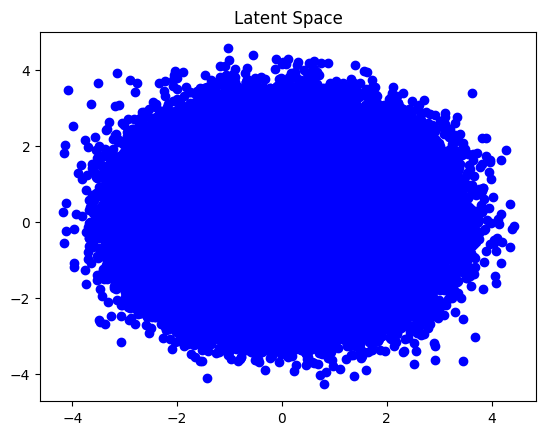

In [155]:
using_beta_vae = True
n_epochs = 40
for beta_level in [1/1000, 1/500,1/200,1/100]:
    print(f'[Training beta = {beta_level}]')
    run(NaiveVAE,epochs=n_epochs,beta=beta_level)
    run(VAE,epochs=n_epochs,beta=beta_level)

You've identified a very common issue in VAEs known as "posterior collapse" or "KL vanishing." This happens when the KL divergence term quickly approaches zero while the reconstruction loss remains high. Here's what's happening and how to fix it:

### What's Happening
Your KL divergence is quickly dropping to nearly zero (from 0.0092 to 0.0000)
Your reconstruction loss remains high (staying around 0.068)
This means your model is ignoring the latent space and is not learning a meaningful distribution
In posterior collapse, the model learns to ignore the latent variable z and the encoder outputs a posterior distribution that matches the prior (standard normal) regardless of the input. This effectively turns your VAE into a deterministic autoencoder.

### Why This Happens
Optimization Imbalance: It's easier for the model to reduce the KL divergence (by making the encoder output match the prior) than to improve reconstruction.
Too Simple Decoder: If your decoder is powerful enough, it can learn to ignore z and still generate reasonable reconstructions.
Lack of Control: Without proper weighting, the KL term can dominate early training then collapse.

### Fix
By experiments, it shows that the numerical level of KL divergences, is approximately 30 multiples of the reconstruction error, if using `reduction='mean'`. It can be fixed by manually set a $beta = 1/784$ at the beginning. It is safe to set beta even smaller as the priority is to reduce the reconstruction error. I tried dynamic beta scheduling for small epochs, but it is not any better.

As a matter of fact, the formula of ELBO is 1/2 the mse_sum. The sum matches the theoretical formula better. I made the decision of 'mean' purely for granted and this is the consequence.

# However
The problem is not solved. The output is of low quality.